-------- > epoch 1:  coût moyen entraînement = 0.2502087354660034
-------- > epoch 1:  taux moyen entraînement = 0.9377408623695374
-------- > epoch 1:  coût moyen validation = 0.10910564661026001
-------- > epoch 1:  taux moyen validation = 0.9704001545906067
-------- > epoch 2:  coût moyen entraînement = 0.09145248681306839
-------- > epoch 2:  taux moyen entraînement = 0.9748209714889526
-------- > epoch 2:  coût moyen validation = 0.07749021053314209
-------- > epoch 2:  taux moyen validation = 0.9767001867294312
-------- > epoch 3:  coût moyen entraînement = 0.07086015492677689
-------- > epoch 3:  taux moyen entraînement = 0.9797800779342651
-------- > epoch 3:  coût moyen validation = 0.064176045358181
-------- > epoch 3:  taux moyen validation = 0.9822002649307251
-------- > epoch 4:  coût moyen entraînement = 0.059747349470853806
-------- > epoch 4:  taux moyen entraînement = 0.9825798869132996
-------- > epoch 4:  coût moyen validation = 0.05781607702374458
-------- > epoch 4

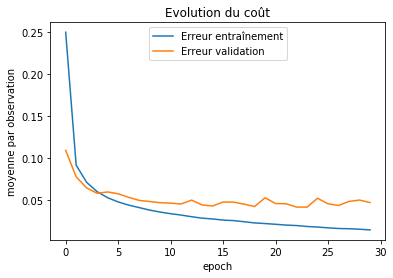

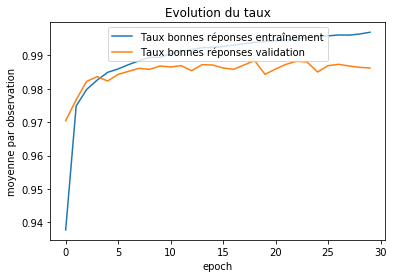

In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Exemple simple de MNIST avec PyTorch
Exemple avec nn.Conv2d et F.cross_entropy
Production de métriques avec graphes
Fonction entrainer
"""
import torch
torch.manual_seed(0) # Pour résultats reproductibles

# Fonction J d'entropie croisée
import torch.nn.functional as F
fonction_cout = F.cross_entropy

def taux_bonnes_predictions(lot_Y_predictions, lot_Y):
    predictions_categorie = torch.argmax(lot_Y_predictions, dim=1)
    return (predictions_categorie == lot_Y).float().mean()

from torch import nn
# Définition de l'architecture du RNA

modele = nn.Sequential(
    nn.Conv2d(1,32,3,padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32,16,3),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(6*6*16,10)
)
    
from torch import optim
optimiseur = optim.SGD(modele.parameters(), lr=0.01, momentum = 0.5)

# Chargement des données de MNIST
import pickle, gzip
fichier_donnees = gzip.open(r"mnist.pkl.gz", 'rb')
((donnees_ent_X, donnees_ent_Y),(donnees_valid_X, donnees_valid_Y),(donnees_test_X,donnees_test_Y)) = pickle.load(fichier_donnees, encoding="latin-1")
fichier_donnees.close()

# Conversion des données en type toch.Tensor
import torch
donnees_ent_X,donnees_ent_Y,donnees_valid_X,donnees_valid_Y,donnees_test_X,donnees_test_Y  = map(torch.tensor,
    (donnees_ent_X.reshape((-1,1,28,28)),donnees_ent_Y,donnees_valid_X.reshape((-1,1,28,28)),donnees_valid_Y,donnees_test_X.reshape((-1,1,28,28)),donnees_test_Y))

# Création des objets DataLoader pour itérer par lot
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
ds_ent = TensorDataset(donnees_ent_X, donnees_ent_Y)
dl_ent = DataLoader(ds_ent, batch_size=100, shuffle=True)
ds_valid = TensorDataset(donnees_valid_X,donnees_valid_Y)
dl_valid = DataLoader(ds_valid, batch_size=100)

def entrainer(modele, dl_ent, dl_valid, optimiseur, nb_epochs=10):

    # Listes pour les métriques par epoch
    liste_cout_moyen_ent = []
    liste_taux_moyen_ent = []
    liste_cout_moyen_valid = []
    liste_taux_moyen_valid = []
    
    # Boucle d'apprentissage
    for epoch in range(nb_epochs):
        cout_total_ent = 0 # pour cumuler les couts par mini-lot
        taux_bonnes_predictions_ent = 0 # pour cumuler les taux par mini-lot
        modele.train() # Pour certains types de couches (nn.BatchNorm2d, nn.Dropout, ...)
        
        # Boucle d'apprentissage par mini-lot pour une epoch
        for lot_X, lot_Y in dl_ent:
            optimiseur.zero_grad() # Remettre les dérivées à zéro
            lot_Y_predictions = modele(lot_X) # Appel de la méthode forward
            cout = fonction_cout(lot_Y_predictions, lot_Y)
            cout.backward() # Calcul des gradiants par rétropropagation
            with torch.no_grad():
                cout_total_ent +=cout
                taux_bonnes_predictions_ent += taux_bonnes_predictions(lot_Y_predictions, lot_Y)
            optimiseur.step() # Mise à jour des paramètres
        # Calculer les moyennes par mini-lot
        with torch.no_grad():
            cout_moyen_ent = cout_total_ent/len(dl_ent)
            taux_moyen_ent = taux_bonnes_predictions_ent/len(dl_ent)
       
        modele.eval() # Pour certains types de couches (nn.BatchNorm2d, nn.Dropout, ...)
        with torch.no_grad():
            cout_valid = sum(fonction_cout(modele(lot_valid_X), lot_valid_Y) for lot_valid_X, lot_valid_Y in dl_valid)
            taux_bons_valid = sum(taux_bonnes_predictions(modele(lot_valid_X), lot_valid_Y) for lot_valid_X, lot_valid_Y in dl_valid)
        cout_moyen_valid = cout_valid/len(dl_valid)
        taux_moyen_valid = taux_bons_valid/len(dl_valid)
        print(f'-------- > epoch {epoch+1}:  coût moyen entraînement = {cout_moyen_ent}')
        print(f'-------- > epoch {epoch+1}:  taux moyen entraînement = {taux_moyen_ent}')
        print(f'-------- > epoch {epoch+1}:  coût moyen validation = {cout_moyen_valid}')
        print(f'-------- > epoch {epoch+1}:  taux moyen validation = {taux_moyen_valid}')
    
        liste_cout_moyen_ent.append(cout_moyen_ent)
        liste_taux_moyen_ent.append(taux_moyen_ent)
        liste_cout_moyen_valid.append(cout_moyen_valid)
        liste_taux_moyen_valid.append(taux_moyen_valid)
    
    # Affichage du graphique d'évolution des métriques par epoch
    import numpy as np
    import matplotlib.pyplot as plt
    plt.plot(np.arange(0,nb_epochs),liste_cout_moyen_ent,label='Erreur entraînement')
    plt.plot(np.arange(0,nb_epochs),liste_cout_moyen_valid,label='Erreur validation')
    plt.title("Evolution du coût")
    plt.xlabel('epoch')
    plt.ylabel('moyenne par observation')
    plt.legend(loc='upper center')
    plt.show()
        
    plt.plot(np.arange(0,nb_epochs),liste_taux_moyen_ent,label='Taux bonnes réponses entraînement')
    plt.plot(np.arange(0,nb_epochs),liste_taux_moyen_valid,label='Taux bonnes réponses validation')
    plt.title("Evolution du taux")
    plt.xlabel('epoch')
    plt.ylabel('moyenne par observation')
    plt.legend(loc='upper center')
    plt.show()

entrainer(modele, dl_ent, dl_valid, optimiseur, nb_epochs=30)